## Lab3 Part 2

Lab3 is splitted into two parts as it is gettign really long.
## Task 5.1 Dynamic Programming
The goal of this second half of the lab is to investigate dynamic progamming along scanlines in stereo vision.  In this part of the practical, we build a basic dynamic programming algorithm, which will solve the same problem as presented in the notes.  

In Task5 we will apply this to the stereo problem.  

Use the template below, filling in parts marked "TO DO" (only todo for Task 5.1 one is in functions.py).



In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from functions_selina import dynamicProgram
plt.close('all')

In [3]:
# define unary costs : unaryCosts[d,j] represents the cost for having
# disparity d at pixel j.
unaryCosts = np.array([[2.0, 1.1, 5.7, 1.5, 6.0, 3.1],
              [0.8, 4.8, 1.0, 3.0, 6.9, 3.3],
              [4.3, 2.3, 2.4, 2.4, 6.6, 6.2],
              [6.4, 0.0, 6.1, 0.8, 7.1, 2.1],
              [2.3, 2.2, 4.9, 8.9, 1.0, 9.8]])

# define pairwise costs:  pairwiseCosts[a,b] represents the cost for changing from 
# disparity level A at pixel j to disparity level B at pixel j+1;
pairwiseCosts = np.array([[   0,   2, 100, 100, 100],
                          [   2,   0,   2, 100, 100],
                          [ 100,   2,   0,   2, 100],
                          [ 100, 100,   2,   0,   2],
                          [ 100, 100, 100,   2,   0]])



In [4]:
# TODO Fill in the dynamicProgram function in "functions.py"

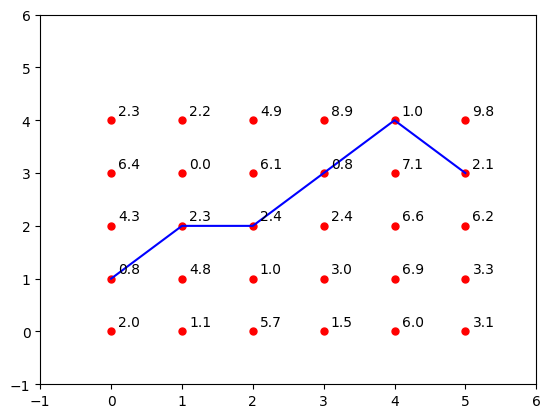

Path Cost = 27.8


In [17]:
from functions_selina import dynamicProgram_efficient

# Now, use dynamic programming to find best solution.
bestPath1 = dynamicProgram(unaryCosts,pairwiseCosts)
bestPath2 = dynamicProgram_efficient(unaryCosts,pairwiseCosts)

# display the nodes
nY = len(unaryCosts)
nX = len(unaryCosts[0])
plt.axis([-1, 6, -1, 6])
for cY in range(nY):
    for cX in range(nX):
        plt.plot(cX,cY,'ro',ms=5.)
        plt.text(cX+.1, cY+.1, unaryCosts[cY,cX])


# display the best path

plt.plot(range(nX),bestPath1,'b-')
# plt.plot(range(nX),bestPath2,'g--')
plt.show()

# calculate the cost of the path computed
bestPathCostUnary = np.sum((np.transpose(unaryCosts).reshape((nX*nY,1)))[(np.add(nY * np.array(range(nX)),np.transpose(bestPath)[0])).astype(int)])
bestPathCostPairwise = np.sum(np.transpose(pairwiseCosts).reshape((nY*nY,1))[np.array([bestPath[0:-1]+nY*bestPath[1:]]).reshape((1,nY)).astype(int)[0]])
bestCost = bestPathCostUnary+bestPathCostPairwise
print('Path Cost =',bestCost)

## Task 5.2 Dynamic Programming for stereo depth estimation


The goal of this part of the practical is to use the dynamic programming routine that you developed in the first part to solve the dense stero problem.

Use the template below, filling in parts marked "TO DO".

### Extra Tasks:
Task hint: Crop or downsample your image if your stereo is slow

Task1: Capture or find two image pairs: one with good stereo depth and one with bad stereo depth. Note that you should only the two camera have a known, and there should be no moving objects in the scene.

Task2: Measure your baseline distance between the camera with a ruler, does the depth esimation match the real distance？

Task3: (Unmarked Optional) Can you use two cameras at the same time for stereo capture?

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from functions_selina import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# load in images and ground truth
data = loadmat('../dataset/StereoData.mat')
im1 = data['im1'].astype('int')
im2 = data['im2'].astype('int')
gt = data['gt'].astype('int')

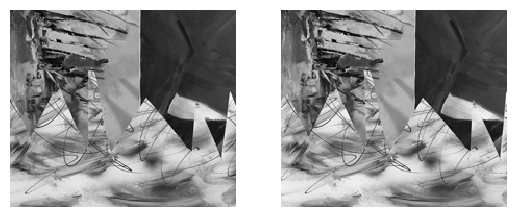

In [8]:
# ground truth disparity is originally expressed in 16'ths of pixels but we 
# will only consider whole-pixel shifts
gtDisp = np.round(gt.astype(float)/16)

im1show = im1
im2show = im2
if np.max(im1) > 1:
    im1show = im1.astype(float)/255.
    im2show = im2.astype(float)/255.
    
# display image
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(im2, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
plt.show()

### Complete the TODOs in the final cell below

Here we are going to make use of the "dynamicProgram" function we just wrote.

We will first calculate the unary costs before using our function to calculate estimated disparity.

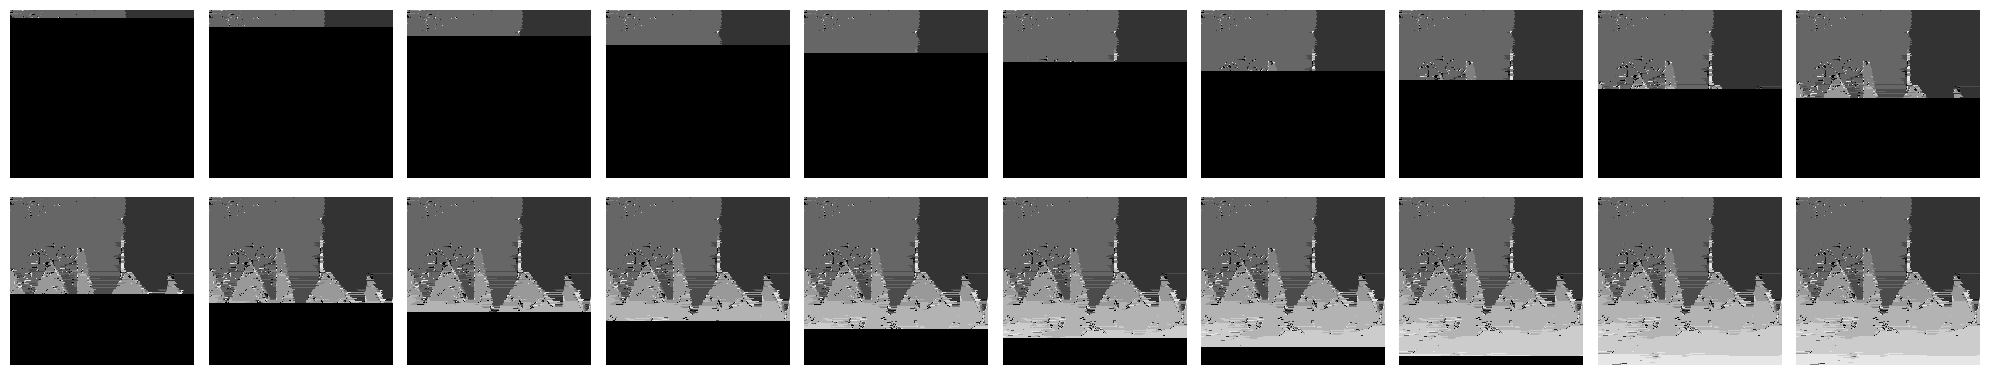

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

def dynamicProgram_stereo_depth_estimation(img1, img2, alpha, noiseSD):
    # figure out size of image
    imY, imX = img1.shape
    
    # define maximum disparity 
    maxDisp = 10
    
    # set up pairwiseCosts - we will define a fixed cost of alpha for changing
    # disparity or zero cost for staying the same
    # alpha = 1
    pairwiseCosts = alpha*np.ones([maxDisp,maxDisp])-alpha*np.eye(maxDisp)
    
    # initialize the disparity map that we will estimate
    estDisp = np.zeros([imY,imX-maxDisp])
    
    # define standard deviation of noise
    # noiseSD = 6
    
    # display ground truth and estimated disparity
    # plt.close('all')
    # f, (ax1, ax2) = plt.subplots(1, 2)
    # ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
    # ax1.axis('off')
    # ax1.set_title('Ground Truth')
    # ax2.axis('off')
    # plt.show()

    # For intermediate visualization
    disparity_snapshots = []  # Store snapshots of disparity at different scanlines
    count = 0

    # run through each line of image
    for cY in range(imY):
        # print('Procesing scanline ',cY)
        count += 1

        # define unary costs - we will not use the last few columns of the
        # image as the disparity might map the pixel outside the valid area of
        # the second image
        unaryCosts = np.zeros([maxDisp,imX-maxDisp])
        
        for cDisp in range(maxDisp):
            cost=np.zeros(imX-maxDisp)
            for cX in range(imX-maxDisp):

                intensity1 = img1[cY, cX]              
                intensity2 = img2[cY, cX + cDisp]      
                likelihood = np.exp(-((intensity1 - intensity2) ** 2) / (2 * noiseSD ** 2))
                cost[cX] = -np.log(likelihood)
    
            unaryCosts[cDisp, :] = cost 

        # Update estimated disparity map
        estDisp[cY,:] = np.transpose(dynamicProgram(unaryCosts,pairwiseCosts))
        
        # Store intermediate disparity map every 20 scanlines
        count += 1
        if count == 20:
            disparity_snapshots.append((cY, estDisp.copy()))
            count = 0

    # Final snapshot
    disparity_snapshots.append((imY - 1, estDisp))

    # Plot the snapshots and the final disparity
    num_snapshots = len(disparity_snapshots)
    cols = 10  # Number of images per row
    rows = (num_snapshots + cols - 1) // cols  # Calculate the required number of rows
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 2))
    axes = axes.flatten()  # Flatten axes to iterate easily
    
    for idx, (scanline, disparity) in enumerate(disparity_snapshots):
        axes[idx].imshow(disparity, cmap='gray', interpolation='nearest', vmin=0, vmax=maxDisp)
        axes[idx].axis('off')  # Remove axis and title
    
    # Hide unused subplots
    for idx in range(len(disparity_snapshots), len(axes)):
        axes[idx].axis('off')
        
    plt.subplots_adjust(wspace=0.01, hspace=0.02)  # Reduce horizontal (wspace) and adjust vertical (hspace)

    plt.tight_layout()
    plt.show()



# alpha_values = [0.5, 1, 2, 3]
# noiseSD_values = [4, 6, 8]

alpha = 1
noiseSD = 6

# for alpha in alpha_values:
#     for noiseSD in noiseSD_values:
#         print("###################################################################################################")
#         print("alpha = ", alpha, " noiseSD = ", noiseSD, "")
dynamicProgram_stereo_depth_estimation(im1, im2, alpha, noiseSD)





## Extra Task 1: Improving Computation Efficiency

rewrite the the "dynamicProgram" in the "dynamicProgramVec" function to make it more efficient. 

Check the improvements by timining the function calls.

Execution time: 0.0408 seconds


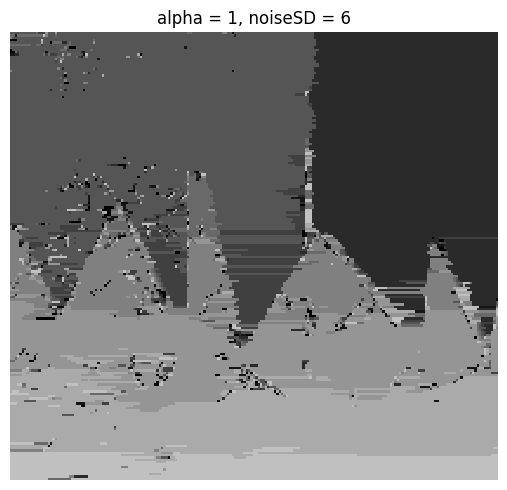

Execution time: 0.0027 seconds


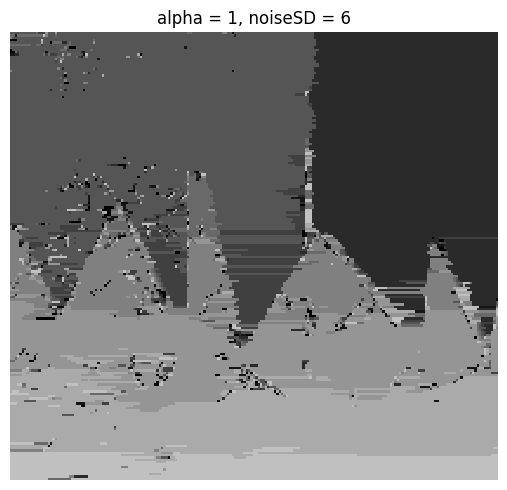

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from functions_selina import dynamicProgram, dynamicProgram_efficient, dynamicProgramVec

def plot_estimated_disparity_extra(img1, img2, alpha, noiseSD, mode_1 ,mode_2="standard"):
    if mode_1 == "Dynamic Program":
        estDisp = dynamicProgram_stereo_depth_estimation_extra_1(img1, img2, alpha, noiseSD, mode_2)

    elif mode_1 == "Unary Cost":
        estDisp = dynamicProgram_stereo_depth_estimation_extra_2(img1, img2, alpha, noiseSD, mode_2)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(estDisp, vmin=0, vmax=12, cmap='gray', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'alpha = {alpha}, noiseSD = {noiseSD}')
    
    plt.tight_layout()
    plt.show()


def dynamicProgram_stereo_depth_estimation_extra_1(img1, img2, alpha, noiseSD, mode="standard"):
    imY = len(img1)
    imX = len(img1[0])
    maxDisp = 10
    pairwiseCosts = alpha * np.ones([maxDisp, maxDisp]) - alpha * np.eye(maxDisp)
    estDisp = np.zeros([imY, imX - maxDisp])
    
    for cY in range(imY):
        unaryCosts = np.zeros([maxDisp, imX - maxDisp])
        
        for cDisp in range(maxDisp):
            cost = np.zeros(imX - maxDisp)
            for cX in range(imX - maxDisp):
                intensity1 = img1[cY, cX]
                intensity2 = img2[cY, cX + cDisp]
                likelihood = np.exp(-((intensity1 - intensity2) ** 2) / (2 * noiseSD ** 2))
                cost[cX] = -np.log(likelihood)
            unaryCosts[cDisp, :] = cost
        
        if mode == "standard":
            start_time = time.time()
            estDisp[cY, :] = np.transpose(dynamicProgram(unaryCosts, pairwiseCosts))
            end_time = time.time()
        elif mode == "efficient":
            start_time = time.time()
            estDisp[cY, :] = np.transpose(dynamicProgram_efficient(unaryCosts, pairwiseCosts))
            end_time = time.time()
    
    print(f"Execution time: {end_time - start_time:.4f} seconds")

    return estDisp


def dynamicProgram_stereo_depth_estimation_extra_2(img1, img2, alpha, noiseSD, mode="standard"):
    imY = len(img1)
    imX = len(img1[0])
    maxDisp = 10
    pairwiseCosts = alpha * np.ones([maxDisp, maxDisp]) - alpha * np.eye(maxDisp)
    estDisp = np.zeros([imY, imX - maxDisp])
    

    start_time = time.time()
    if mode == "standard":
        start_time = time.time()

        for cY in range(imY):
            unaryCosts = np.zeros([maxDisp, imX - maxDisp])
            row1 = img1[cY, :imX - maxDisp]  # Shape: (imX - maxDisp,)
            row2 = img2[cY, :]  # Shape: (imX,)
            for cDisp in range(maxDisp):
                cost = np.zeros(imX - maxDisp)
                for cX in range(imX - maxDisp):
                    intensity1 = img1[cY, cX]
                    intensity2 = img2[cY, cX + cDisp]
                    likelihood = np.exp(-((intensity1 - intensity2) ** 2) / (2 * noiseSD ** 2))
                    cost[cX] = -np.log(likelihood)
                unaryCosts[cDisp, :] = cost

            estDisp[cY, :] = np.transpose(dynamicProgram(unaryCosts, pairwiseCosts))

        end_time = time.time()
        print(f"Standard method execution time: {end_time - start_time:.4f} seconds")

    elif mode == "efficient":
        start_time = time.time()

        # Preallocate unaryCosts
        unaryCosts = np.zeros([imY, maxDisp, imX - maxDisp])  # Shape: (imY, maxDisp, imX - maxDisp)

        # Loop over all disparities in one vectorized operation
        for cDisp in range(maxDisp):
            
            # Extract shifted version of img2
            shifted_img2 = img2[:, cDisp:imX - maxDisp + cDisp]  # Shape: (imY, imX - maxDisp)
            
            # Compute intensity differences
            diff = img1[:, :imX - maxDisp] - shifted_img2  # Shape: (imY, imX - maxDisp)
            
            # Compute unary cost for this disparity
            likelihood = np.exp(-(diff ** 2) / (2 * noiseSD ** 2))  # Gaussian Likelihood
            unaryCosts[:, cDisp, :] = -np.log(likelihood)  # Store the result
        
        end_time = time.time()
        print(f"Optimized method execution time: {end_time - start_time:.4f} seconds")

        for cY in range(imY):
            estDisp[cY, :] = np.transpose(dynamicProgram(unaryCosts[cY], pairwiseCosts))



    elif mode == "super_efficient":
        
        start_time = time.time()

        # Preallocate unaryCosts
        unaryCosts = np.zeros([imY, maxDisp, imX - maxDisp])  # Shape: (imY, maxDisp, imX - maxDisp)

        # Create shifted versions of img2 for all disparities
        shifted_img2 = np.array([
            img2[:, cDisp:imX - maxDisp + cDisp] for cDisp in range(maxDisp)
        ])  # Shape: (maxDisp, imY, imX - maxDisp)

        # Compute intensity differences for all disparities
        diff = img1[:, :imX - maxDisp][np.newaxis, :, :] - shifted_img2  # Shape: (maxDisp, imY, imX - maxDisp)

        # Compute unary costs
        likelihood = np.exp(-(diff ** 2) / (2 * noiseSD ** 2))  # Gaussian Likelihood
        unaryCosts = -np.log(likelihood)  # Shape: (imY, maxDisp, imX - maxDisp)
    
        end_time = time.time()
        print(f"Super Optimized method execution time: {end_time - start_time:.4f} seconds")

        for cY in range(imY):
            estDisp[cY, :] = np.transpose(dynamicProgram(unaryCosts[cY], pairwiseCosts))

        
    return estDisp

import timeit

# execution_time = timeit.timeit(
#     "plot_estimated_disparity_extra_1()",  # 调用优化后的函数
#     setup="from __main__ import plot_estimated_disparity_extra_1",  # 必要的导入
#     number=10  # 重复运行 10 次
# )
# print(f"Average execution time over 10 runs: {execution_time / 10:.4f} seconds")

plot_estimated_disparity_extra(im1, im2, 1, 6, mode_1 = "Dynamic Program", mode_2="standard")
plot_estimated_disparity_extra(im1, im2, 1, 6, mode_1 = "Dynamic Program", mode_2="efficient")

# plot_estimated_disparity_extra(im1, im2, 1, 6, mode_1 = "Unary Cost", mode_2="standard")
# plot_estimated_disparity_extra(im1, im2, 1, 6, mode_1 = "Unary Cost", mode_2="efficient")
# plot_estimated_disparity_extra(im1, im2, 1, 6, mode_1 = "Unary Cost", mode_2="super_efficient")



## Extra Task 2
you should be able to rewrite this (calculating unary costs) with fewer loops once you have

the general idea so that it runs faster. Again you can check the speed improvements by timing them.



## Extra Task 3:
adapt the algorithm so that it makes use of colour information

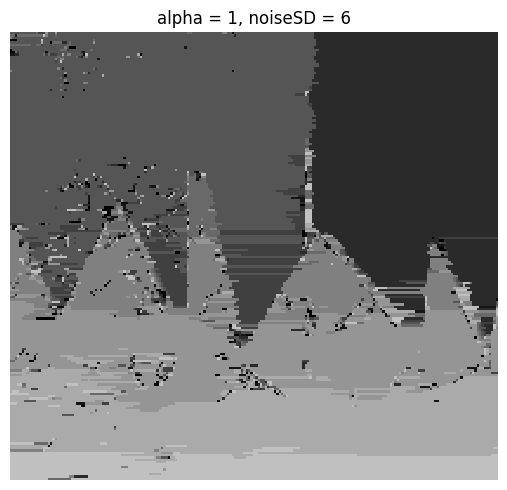

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_estimated_disparity(img1, img2, alpha, noiseSD):
    estDisp = dynamicProgram_stereo_depth_estimation(img1, img2, alpha, noiseSD)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(estDisp, vmin=0, vmax=12, cmap='gray', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'alpha = {alpha}, noiseSD = {noiseSD}')
    
    plt.tight_layout()
    plt.show()


def dynamicProgram_stereo_depth_estimation(img1, img2, alpha, noiseSD):
    imY = len(img1)
    imX = len(img1[0])
    maxDisp = 10
    pairwiseCosts = alpha * np.ones([maxDisp, maxDisp]) - alpha * np.eye(maxDisp)
    estDisp = np.zeros([imY, imX - maxDisp])
    
    for cY in range(imY):
        unaryCosts = np.zeros([maxDisp, imX - maxDisp])
        
        for cDisp in range(maxDisp):
            cost = np.zeros(imX - maxDisp)
            for cX in range(imX - maxDisp):
                intensity1 = img1[cY, cX]
                intensity2 = img2[cY, cX + cDisp]
                likelihood = np.exp(-((intensity1 - intensity2) ** 2) / (2 * noiseSD ** 2))
                cost[cX] = -np.log(likelihood)
            unaryCosts[cDisp, :] = cost
        
        estDisp[cY, :] = np.transpose(dynamicProgram(unaryCosts, pairwiseCosts))
    
    return estDisp


plot_estimated_disparity(im1, im2, 1, 6)


In [ ]:

def plot_estimated_disparity(img1, img2, alpha_values, noiseSD_values):
    for alpha in alpha_values:
        fig, axes = plt.subplots(1, len(noiseSD_values), figsize=(15, 5))
        fig.suptitle(f'Estimated Disparity for alpha = {alpha}')
        
        for i, noiseSD in enumerate(noiseSD_values):
            estDisp = dynamicProgram_stereo_depth_estimation(img1, img2, alpha, noiseSD)
            ax = axes[i]
            ax.imshow(estDisp, vmin=0, vmax=12, cmap='gray', interpolation='nearest')
            ax.axis('off')
            ax.set_title(f'noiseSD = {noiseSD}')
        
        plt.show()

def dynamicProgram_stereo_depth_estimation(img1, img2, alpha, noiseSD):
    imY = len(img1)
    imX = len(img1[0])
    maxDisp = 10
    pairwiseCosts = alpha * np.ones([maxDisp, maxDisp]) - alpha * np.eye(maxDisp)
    estDisp = np.zeros([imY, imX - maxDisp])
    
    for cY in range(imY):
        unaryCosts = np.zeros([maxDisp, imX - maxDisp])
        
        for cDisp in range(maxDisp):
            cost = np.zeros(imX - maxDisp)
            for cX in range(imX - maxDisp):
                intensity1 = img1[cY, cX]
                intensity2 = img2[cY, cX + cDisp]
                likelihood = np.exp(-((intensity1 - intensity2) ** 2) / (2 * noiseSD ** 2))
                cost[cX] = -np.log(likelihood)
            unaryCosts[cDisp, :] = cost
        
        estDisp[cY, :] = np.transpose(dynamicProgram(unaryCosts, pairwiseCosts))
    
    return estDisp

    
# TODO - investigate how different values of alpha and noiseSD affect the results
alpha_values = [0.5, 1, 2, 3]
noiseSD_values = [4, 6, 8]

# for alpha in alpha_values:
#     for noiseSD in noiseSD_values:
#         print("###################################################################################################")
#         print("alpha = ", alpha, " noiseSD = ", noiseSD, "")
#         dynamicProgram_stereo_depth_estimation(im1, im2, alpha, noiseSD)

plot_estimated_disparity(im1, im2, alpha_values, noiseSD_values)